[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [ ]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Fri Apr 11 11:53:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   45C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [3]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 105.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [4]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-04-11 11:55:48--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-04-11 11:55:48 (110 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 51.4M/51.4M [00:00<00:00, 344MB/s]


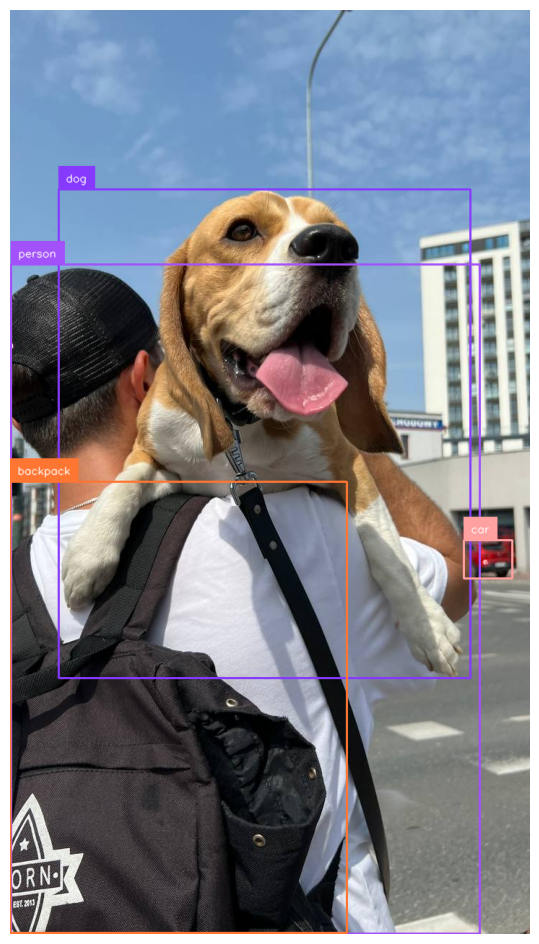

In [5]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [8]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="r5lnD6LwaGcnyQXz083B")
project = rf.workspace("giki-yybfj").project("urine-sediment-yolov8")
version = project.version(3)
dataset = version.download("yolov12")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Urine-sediment-Yolov8-3 in yolov12:: 100%|██████████| 11272/11272 [00:01<00:00, 8813.52it/s]


In [9]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [10]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [11]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 10
names: ['Platelets', 'RBC', 'WBC', 'cast', 'cryst', 'epith', 'epithn', 'eryth', 'leuko', 'mycete']

roboflow:
  workspace: giki-yybfj
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [12]:


from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=100)

New https://pypi.org/project/ultralytics/8.3.107 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/Urine-sediment-Yolov8-3/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sh

100%|██████████| 755k/755k [00:00<00:00, 140MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytic

100%|██████████| 5.26M/5.26M [00:00<00:00, 318MB/s]


AMP: checks passed ✅


train: Scanning /content/Urine-sediment-Yolov8-3/train/labels... 5064 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5064/5064 [00:03<00:00, 1491.92it/s]


train: New cache created: /content/Urine-sediment-Yolov8-3/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 25, len(boxes) = 43004. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/Urine-sediment-Yolov8-3/valid/labels... 284 images, 0 backgrounds, 0 corrupt: 100%|██████████| 284/284 [00:00<00:00, 1120.71it/s]

val: New cache created: /content/Urine-sediment-Yolov8-3/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: WARNING ⚠️ TensorBoard graph visualization failure Tracing failed sanity checks!
ERROR: Graphs differed across invocations!
	Graph diff:
		  graph(%self.1 : __torch__.ultralytics.nn.tasks.DetectionModel,
		        %x.1 : Tensor):
		    %model : __torch__.torch.nn.modules.container.Sequential = prim::GetAttr[name="model"](%self.1)
		    %_21 : __torch__.ultralytics.nn.modules.head.Detect = prim::GetAttr[name="21"](%model)
		    %model.43 : __torch__.torch.nn.modules.container.Sequential = prim::GetAttr[name="model"](%self.1)
		    %_20 : __torch__.ultralytics.nn.modules.block.C3k2 = prim::GetAttr[name="20"](%model.43)
		    %model.41 : __torch_

      1/100      11.1G      3.541      4.569      3.346         53        640: 100%|██████████| 317/317 [01:10<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.46it/s]

                   all        284       1733       0.27      0.125     0.0789     0.0289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      9.43G      2.158      2.431      1.766         62        640: 100%|██████████| 317/317 [01:05<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.16it/s]

                   all        284       1733       0.45      0.365      0.317      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      8.63G       1.85      1.903      1.467         77        640: 100%|██████████| 317/317 [01:04<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.37it/s]

                   all        284       1733      0.637      0.369      0.361      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      11.3G      1.738      1.676       1.37        161        640: 100%|██████████| 317/317 [01:04<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.34it/s]


                   all        284       1733       0.39      0.322      0.209      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      9.86G      1.654      1.538      1.326         24        640: 100%|██████████| 317/317 [01:03<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.43it/s]

                   all        284       1733      0.584      0.352      0.328      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      8.22G       1.61      1.469      1.295         89        640: 100%|██████████| 317/317 [01:03<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.56it/s]


                   all        284       1733      0.583      0.646      0.649      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      10.1G      1.589       1.37      1.265         54        640: 100%|██████████| 317/317 [01:04<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.55it/s]


                   all        284       1733      0.568      0.591      0.627      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      10.1G       1.56      1.323      1.238         89        640: 100%|██████████| 317/317 [01:03<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.52it/s]


                   all        284       1733       0.52       0.69      0.656      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      9.71G       1.55      1.264      1.231         56        640: 100%|██████████| 317/317 [01:04<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.51it/s]


                   all        284       1733       0.62      0.691      0.699      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      8.49G      1.523      1.235      1.215         73        640: 100%|██████████| 317/317 [01:04<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.56it/s]


                   all        284       1733      0.645      0.675      0.715      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      8.08G      1.507      1.223      1.213         22        640: 100%|██████████| 317/317 [01:03<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.56it/s]


                   all        284       1733      0.547      0.541       0.53       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      11.4G      1.506      1.186      1.201        142        640: 100%|██████████| 317/317 [01:03<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.40it/s]

                   all        284       1733      0.589      0.663      0.671      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      9.02G      1.481      1.167      1.189         68        640: 100%|██████████| 317/317 [01:03<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.60it/s]


                   all        284       1733      0.728      0.756      0.796       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      8.72G      1.466      1.143      1.188         38        640: 100%|██████████| 317/317 [01:03<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.44it/s]


                   all        284       1733      0.621      0.717      0.705       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      9.64G      1.479      1.141      1.187         58        640: 100%|██████████| 317/317 [01:03<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.54it/s]


                   all        284       1733      0.653      0.696      0.738        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      10.1G      1.467      1.092      1.163         78        640: 100%|██████████| 317/317 [01:04<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.48it/s]


                   all        284       1733      0.662      0.725       0.76      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      9.87G      1.452      1.107      1.172         70        640: 100%|██████████| 317/317 [01:03<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.53it/s]

                   all        284       1733      0.688      0.732       0.77      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      10.7G      1.458      1.083      1.164         47        640: 100%|██████████| 317/317 [01:04<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.56it/s]


                   all        284       1733      0.713      0.681      0.775      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      10.8G      1.439      1.061      1.159         80        640: 100%|██████████| 317/317 [01:04<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.52it/s]


                   all        284       1733        0.7      0.758      0.795      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      9.19G      1.432      1.045      1.158         38        640: 100%|██████████| 317/317 [01:03<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.44it/s]


                   all        284       1733      0.629      0.717      0.731      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      10.7G      1.432      1.044      1.152        115        640: 100%|██████████| 317/317 [01:03<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.57it/s]


                   all        284       1733      0.734      0.801      0.828      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      9.43G      1.435      1.046      1.158         56        640: 100%|██████████| 317/317 [01:03<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.46it/s]

                   all        284       1733      0.701      0.745      0.784       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      9.16G      1.425      1.032      1.141        142        640: 100%|██████████| 317/317 [01:03<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.51it/s]


                   all        284       1733      0.678      0.773      0.805      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      8.07G      1.412      1.002       1.14         72        640: 100%|██████████| 317/317 [01:03<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.51it/s]


                   all        284       1733      0.693      0.777      0.794      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100       9.9G      1.413      1.007      1.145         59        640: 100%|██████████| 317/317 [01:03<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.60it/s]


                   all        284       1733      0.735      0.778      0.814      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      9.71G      1.412      0.993      1.138        200        640: 100%|██████████| 317/317 [01:03<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.53it/s]


                   all        284       1733      0.763      0.768      0.823      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      10.1G      1.414      0.987      1.138         44        640: 100%|██████████| 317/317 [01:04<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.51it/s]

                   all        284       1733      0.768      0.785      0.832       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      9.99G      1.415      0.978      1.131         77        640: 100%|██████████| 317/317 [01:04<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.57it/s]


                   all        284       1733      0.754      0.795       0.83      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      11.2G      1.398     0.9708      1.136         80        640: 100%|██████████| 317/317 [01:03<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.57it/s]


                   all        284       1733      0.772      0.749      0.824       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      9.03G      1.402     0.9628      1.125         80        640: 100%|██████████| 317/317 [01:03<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.61it/s]


                   all        284       1733      0.798      0.772      0.844      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      11.5G      1.392     0.9676      1.131        346        640: 100%|██████████| 317/317 [01:03<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.60it/s]


                   all        284       1733      0.757      0.772      0.823       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.25G      1.391      0.948       1.12        102        640: 100%|██████████| 317/317 [01:04<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.51it/s]


                   all        284       1733      0.804      0.787      0.846      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      9.57G      1.388      0.942      1.121         43        640: 100%|██████████| 317/317 [01:03<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.61it/s]


                   all        284       1733       0.76       0.79      0.831      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.79G      1.385     0.9345      1.121         82        640: 100%|██████████| 317/317 [01:04<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.56it/s]


                   all        284       1733      0.796      0.791      0.859      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100        11G      1.387      0.941      1.124         48        640: 100%|██████████| 317/317 [01:03<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.44it/s]

                   all        284       1733      0.763      0.765      0.832      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      8.87G      1.383     0.9405      1.121         95        640: 100%|██████████| 317/317 [01:03<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.56it/s]


                   all        284       1733      0.764        0.8       0.85      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      9.25G      1.374     0.9344      1.122         51        640: 100%|██████████| 317/317 [01:03<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.57it/s]


                   all        284       1733      0.778      0.817      0.857      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      8.44G      1.369     0.9347      1.112         68        640: 100%|██████████| 317/317 [01:03<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.58it/s]


                   all        284       1733      0.776       0.81      0.852      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      9.04G       1.37     0.9363      1.116         48        640: 100%|██████████| 317/317 [01:03<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.56it/s]


                   all        284       1733      0.758      0.824      0.858      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      9.29G      1.374     0.9279      1.112        115        640: 100%|██████████| 317/317 [01:04<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.49it/s]

                   all        284       1733      0.774      0.773      0.835      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      9.54G      1.365     0.9156      1.103         43        640: 100%|██████████| 317/317 [01:03<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.50it/s]

                   all        284       1733      0.787      0.828      0.865       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      9.26G      1.365     0.9072      1.105         67        640: 100%|██████████| 317/317 [01:04<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.54it/s]


                   all        284       1733      0.781      0.812       0.85      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      11.2G      1.364     0.9098      1.104         60        640: 100%|██████████| 317/317 [01:03<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.52it/s]


                   all        284       1733      0.739      0.802      0.864      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100        12G      1.359     0.9127      1.108         81        640: 100%|██████████| 317/317 [01:03<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.57it/s]

                   all        284       1733      0.804      0.813      0.867      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       8.7G      1.367     0.9013      1.105         59        640: 100%|██████████| 317/317 [01:04<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.47it/s]


                   all        284       1733      0.811      0.826      0.876      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      9.02G      1.353     0.8955      1.102         17        640: 100%|██████████| 317/317 [01:03<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.63it/s]


                   all        284       1733      0.818      0.801      0.874      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      9.37G       1.36     0.8933      1.105         60        640: 100%|██████████| 317/317 [01:03<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.55it/s]


                   all        284       1733      0.772       0.85      0.869      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      10.5G      1.357     0.8895        1.1         71        640: 100%|██████████| 317/317 [01:04<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.60it/s]


                   all        284       1733      0.826      0.793      0.867      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      8.99G      1.354     0.8897      1.097         89        640: 100%|██████████| 317/317 [01:04<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.56it/s]


                   all        284       1733      0.801      0.818      0.876      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      8.67G      1.356     0.9036      1.102        113        640: 100%|██████████| 317/317 [01:03<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.61it/s]


                   all        284       1733      0.805      0.795      0.871      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      10.3G      1.349     0.8803      1.089         85        640: 100%|██████████| 317/317 [01:04<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.60it/s]


                   all        284       1733      0.787       0.86      0.885      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      9.63G      1.341     0.8675      1.089         45        640: 100%|██████████| 317/317 [01:04<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.59it/s]


                   all        284       1733        0.8      0.824      0.875      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       9.4G      1.342     0.8823      1.099         58        640: 100%|██████████| 317/317 [01:03<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.61it/s]


                   all        284       1733      0.796      0.826      0.869      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      9.03G      1.332     0.8689       1.09         62        640: 100%|██████████| 317/317 [01:03<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.56it/s]


                   all        284       1733      0.798      0.833      0.875      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      12.1G      1.348     0.8763       1.09         46        640: 100%|██████████| 317/317 [01:04<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.62it/s]


                   all        284       1733      0.799      0.823      0.876      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      8.97G      1.341     0.8621      1.087         45        640: 100%|██████████| 317/317 [01:04<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.60it/s]


                   all        284       1733      0.812      0.835      0.877      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      9.63G      1.334     0.8731      1.091        163        640: 100%|██████████| 317/317 [01:03<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.58it/s]


                   all        284       1733      0.798      0.845       0.88      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100        11G      1.329     0.8576      1.086         49        640: 100%|██████████| 317/317 [01:03<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.59it/s]


                   all        284       1733      0.813      0.818      0.879       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      9.96G      1.337     0.8605      1.082        107        640: 100%|██████████| 317/317 [01:04<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.55it/s]


                   all        284       1733      0.803      0.836      0.881      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      10.1G      1.324     0.8443      1.084         92        640: 100%|██████████| 317/317 [01:03<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.55it/s]


                   all        284       1733      0.813      0.831      0.881      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      9.64G      1.334     0.8582      1.094         96        640: 100%|██████████| 317/317 [01:03<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.48it/s]


                   all        284       1733      0.781      0.858      0.882       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100        10G      1.327     0.8515      1.079         73        640: 100%|██████████| 317/317 [01:04<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.52it/s]


                   all        284       1733      0.815      0.821      0.882      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      8.55G      1.327     0.8474      1.085         75        640: 100%|██████████| 317/317 [01:03<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.61it/s]


                   all        284       1733      0.793      0.848      0.879      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      8.64G      1.324     0.8437      1.086        221        640: 100%|██████████| 317/317 [01:03<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.54it/s]


                   all        284       1733      0.808      0.839      0.885      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      9.73G      1.323     0.8486      1.085         46        640: 100%|██████████| 317/317 [01:03<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.58it/s]


                   all        284       1733      0.817      0.828      0.886      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      10.8G       1.32     0.8437      1.081         39        640: 100%|██████████| 317/317 [01:03<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.58it/s]


                   all        284       1733      0.803      0.824      0.881      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      8.73G      1.312     0.8381      1.083         52        640: 100%|██████████| 317/317 [01:03<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.60it/s]


                   all        284       1733       0.83      0.825      0.887      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      8.97G      1.321     0.8371      1.083        125        640: 100%|██████████| 317/317 [01:03<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.57it/s]


                   all        284       1733      0.829       0.84      0.888      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      10.4G      1.323     0.8302      1.082         55        640: 100%|██████████| 317/317 [01:03<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.63it/s]


                   all        284       1733      0.818      0.837      0.889      0.536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      10.6G      1.316     0.8212      1.075         63        640: 100%|██████████| 317/317 [01:04<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.54it/s]


                   all        284       1733      0.799      0.856      0.889      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      10.2G       1.31     0.8335      1.082         37        640: 100%|██████████| 317/317 [01:03<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.60it/s]


                   all        284       1733      0.809      0.847      0.891      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      10.5G      1.303     0.8204      1.074         43        640: 100%|██████████| 317/317 [01:03<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.61it/s]


                   all        284       1733      0.796      0.857      0.887      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      10.3G      1.307      0.824      1.075         42        640: 100%|██████████| 317/317 [01:04<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.46it/s]


                   all        284       1733      0.824      0.826      0.888      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100        12G      1.301     0.8174      1.078         92        640: 100%|██████████| 317/317 [01:04<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.53it/s]

                   all        284       1733      0.806      0.838      0.883      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      9.68G      1.307     0.8268      1.076        137        640: 100%|██████████| 317/317 [01:03<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.54it/s]

                   all        284       1733      0.808      0.845      0.891      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       9.6G      1.306     0.8181       1.08        169        640: 100%|██████████| 317/317 [01:04<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.57it/s]


                   all        284       1733      0.801      0.856      0.888      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      10.4G      1.306     0.8191       1.08         44        640: 100%|██████████| 317/317 [01:03<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.65it/s]


                   all        284       1733      0.825      0.847      0.893      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      11.6G      1.302     0.8178      1.076         96        640: 100%|██████████| 317/317 [01:03<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.58it/s]


                   all        284       1733      0.845      0.823      0.893      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      9.52G      1.306     0.8084      1.071         20        640: 100%|██████████| 317/317 [01:04<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.55it/s]


                   all        284       1733      0.802      0.848      0.892      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      8.86G      1.309     0.8087      1.076        600        640: 100%|██████████| 317/317 [01:04<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.49it/s]


                   all        284       1733      0.834      0.832      0.893       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      9.79G      1.299     0.7956      1.067         67        640: 100%|██████████| 317/317 [01:04<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.65it/s]


                   all        284       1733      0.815      0.846      0.895      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      8.39G      1.305     0.8012      1.077         60        640: 100%|██████████| 317/317 [01:03<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.61it/s]


                   all        284       1733      0.803      0.861      0.891      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      8.68G        1.3     0.8053       1.07         58        640: 100%|██████████| 317/317 [01:04<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.64it/s]


                   all        284       1733      0.821       0.84      0.892      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.61G      1.304     0.8117      1.071         83        640: 100%|██████████| 317/317 [01:04<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.58it/s]


                   all        284       1733       0.81      0.862      0.894       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      8.96G      1.294     0.7989      1.073         68        640: 100%|██████████| 317/317 [01:03<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.64it/s]


                   all        284       1733       0.79      0.874      0.896      0.557

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      8.76G      1.295     0.7981      1.068         57        640: 100%|██████████| 317/317 [01:03<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.63it/s]


                   all        284       1733      0.825      0.835      0.893      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      8.83G      1.297     0.7984      1.063         85        640: 100%|██████████| 317/317 [01:04<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.65it/s]


                   all        284       1733      0.818       0.85      0.894      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      8.91G      1.282     0.7911      1.063         67        640: 100%|██████████| 317/317 [01:04<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.59it/s]

                   all        284       1733      0.803      0.865      0.892      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      9.76G       1.29     0.7967       1.07         95        640: 100%|██████████| 317/317 [01:03<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.57it/s]


                   all        284       1733       0.82      0.853      0.895      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      10.8G      1.299     0.8051      1.066        149        640: 100%|██████████| 317/317 [01:03<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.59it/s]


                   all        284       1733      0.803      0.854      0.894      0.554
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      9.27G      1.263     0.7799      1.094         18        640: 100%|██████████| 317/317 [01:03<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.60it/s]


                   all        284       1733      0.822      0.844      0.899      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      8.62G      1.258      0.767      1.088         29        640: 100%|██████████| 317/317 [01:03<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.59it/s]


                   all        284       1733       0.83      0.844        0.9      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      10.9G      1.255     0.7602       1.09         18        640: 100%|██████████| 317/317 [01:03<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.63it/s]


                   all        284       1733      0.809      0.866      0.903      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      9.41G      1.253      0.759      1.085         46        640: 100%|██████████| 317/317 [01:03<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.56it/s]


                   all        284       1733      0.799      0.871        0.9      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      9.84G      1.256     0.7609      1.092         31        640: 100%|██████████| 317/317 [01:03<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.57it/s]


                   all        284       1733      0.824      0.844        0.9      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      9.23G      1.248     0.7589      1.087         30        640: 100%|██████████| 317/317 [01:03<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.58it/s]


                   all        284       1733      0.839      0.832        0.9      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      8.95G      1.249     0.7551      1.087         90        640: 100%|██████████| 317/317 [01:03<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.61it/s]

                   all        284       1733      0.839      0.832      0.902      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      10.9G      1.256     0.7557      1.081         74        640: 100%|██████████| 317/317 [01:03<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.58it/s]


                   all        284       1733      0.818      0.858      0.903      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      12.1G       1.25      0.755      1.089         32        640: 100%|██████████| 317/317 [01:03<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.54it/s]


                   all        284       1733      0.821      0.853      0.902      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      9.82G      1.245       0.75      1.086         34        640: 100%|██████████| 317/317 [01:03<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.53it/s]


                   all        284       1733      0.824      0.845      0.901      0.562

100 epochs completed in 1.864 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLOv12s summary (fused): 376 layers, 9,078,078 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.82it/s]


                   all        284       1733      0.819      0.855      0.902      0.562
             Platelets         13         30      0.927      0.841      0.927      0.503
                   RBC         24        296       0.73      0.757      0.801      0.578
                   WBC         25         26      0.939      0.962       0.97      0.739
                  cast         68        163       0.67      0.681      0.771      0.441
                 cryst         41         66      0.827      0.864      0.931      0.635
                 epith         61        237      0.779      0.924      0.927      0.615
                epithn         27         47      0.837       0.83      0.886      0.444
                 eryth         48        475      0.897      0.968      0.968      0.526
                 leuko         72        269      0.765      0.948      0.937      0.582
                mycete         33        124      0.822       0.78      0.904      0.561
Speed: 0.2ms preproce

## Evaluate fine-tuned YOLOv12 model

In [14]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					    train_batch1.jpg
confusion_matrix_normalized.png			    train_batch28530.jpg
confusion_matrix.png				    train_batch28531.jpg
events.out.tfevents.1744372999.86e3a706d1b8.1245.0  train_batch28532.jpg
F1_curve.png					    train_batch2.jpg
labels_correlogram.jpg				    val_batch0_labels.jpg
labels.jpg					    val_batch0_pred.jpg
P_curve.png					    val_batch1_labels.jpg
PR_curve.png					    val_batch1_pred.jpg
R_curve.png					    val_batch2_labels.jpg
results.csv					    val_batch2_pred.jpg
results.png					    weights
train_batch0.jpg


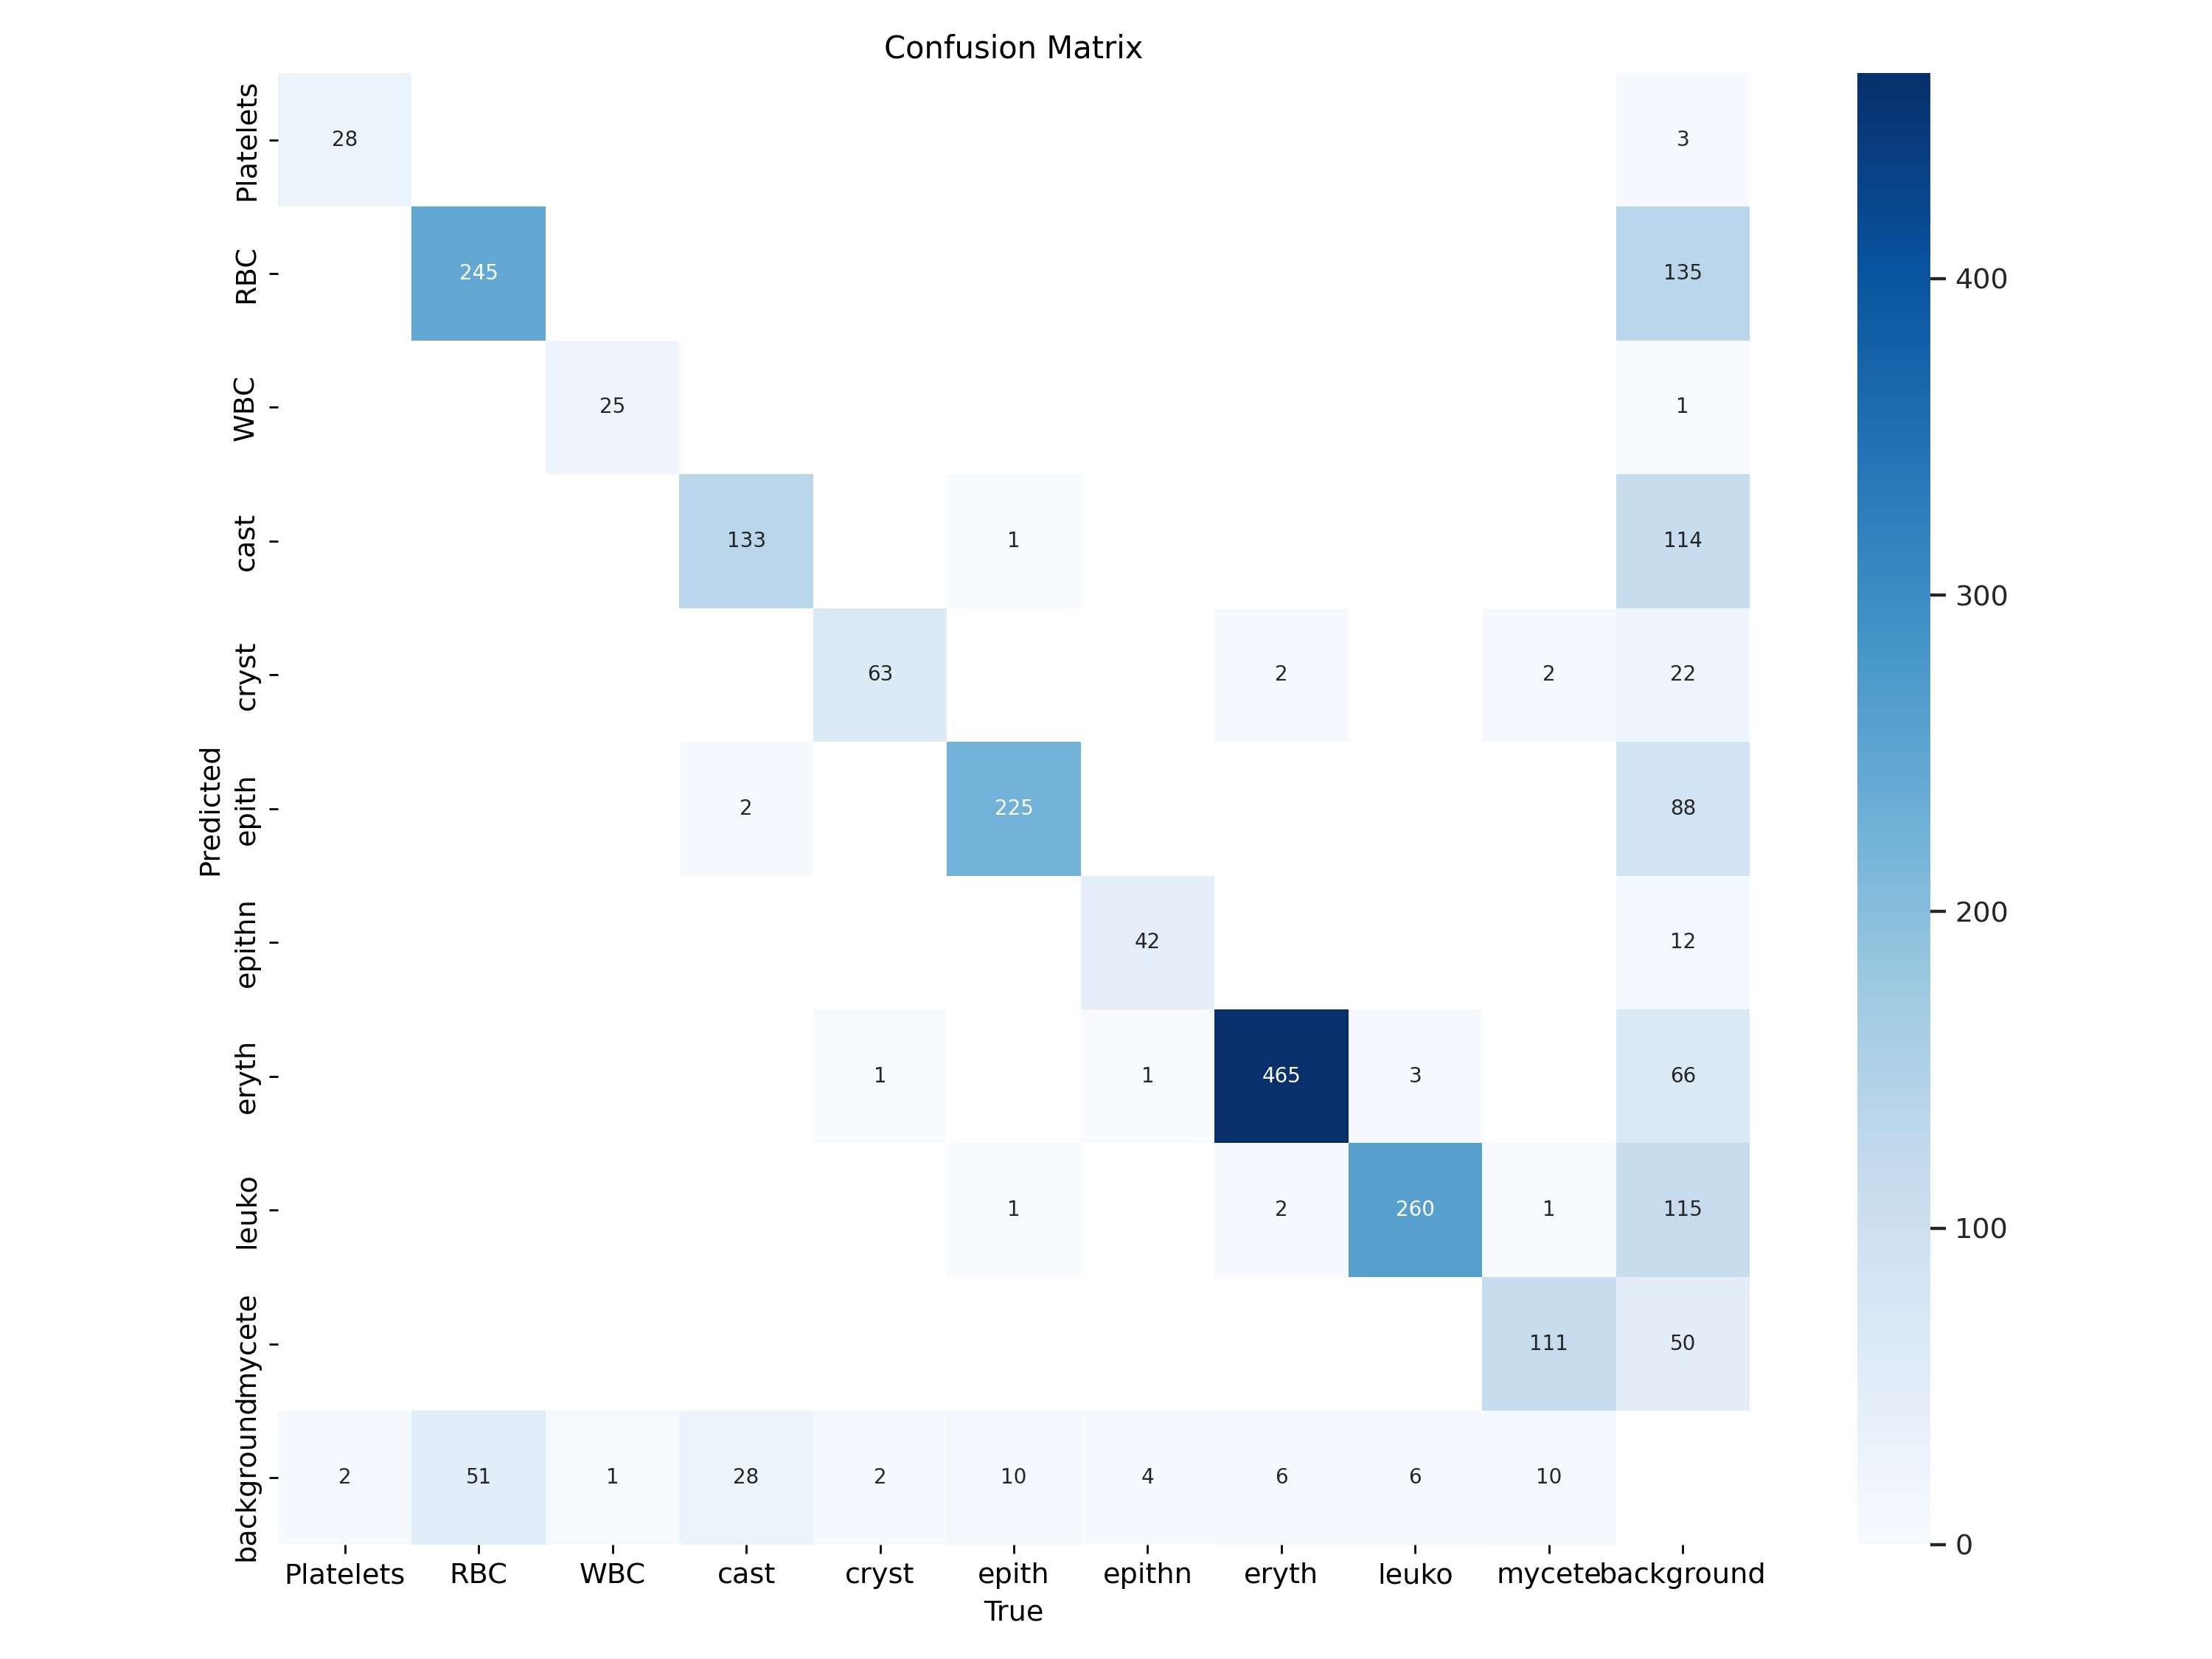

In [15]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

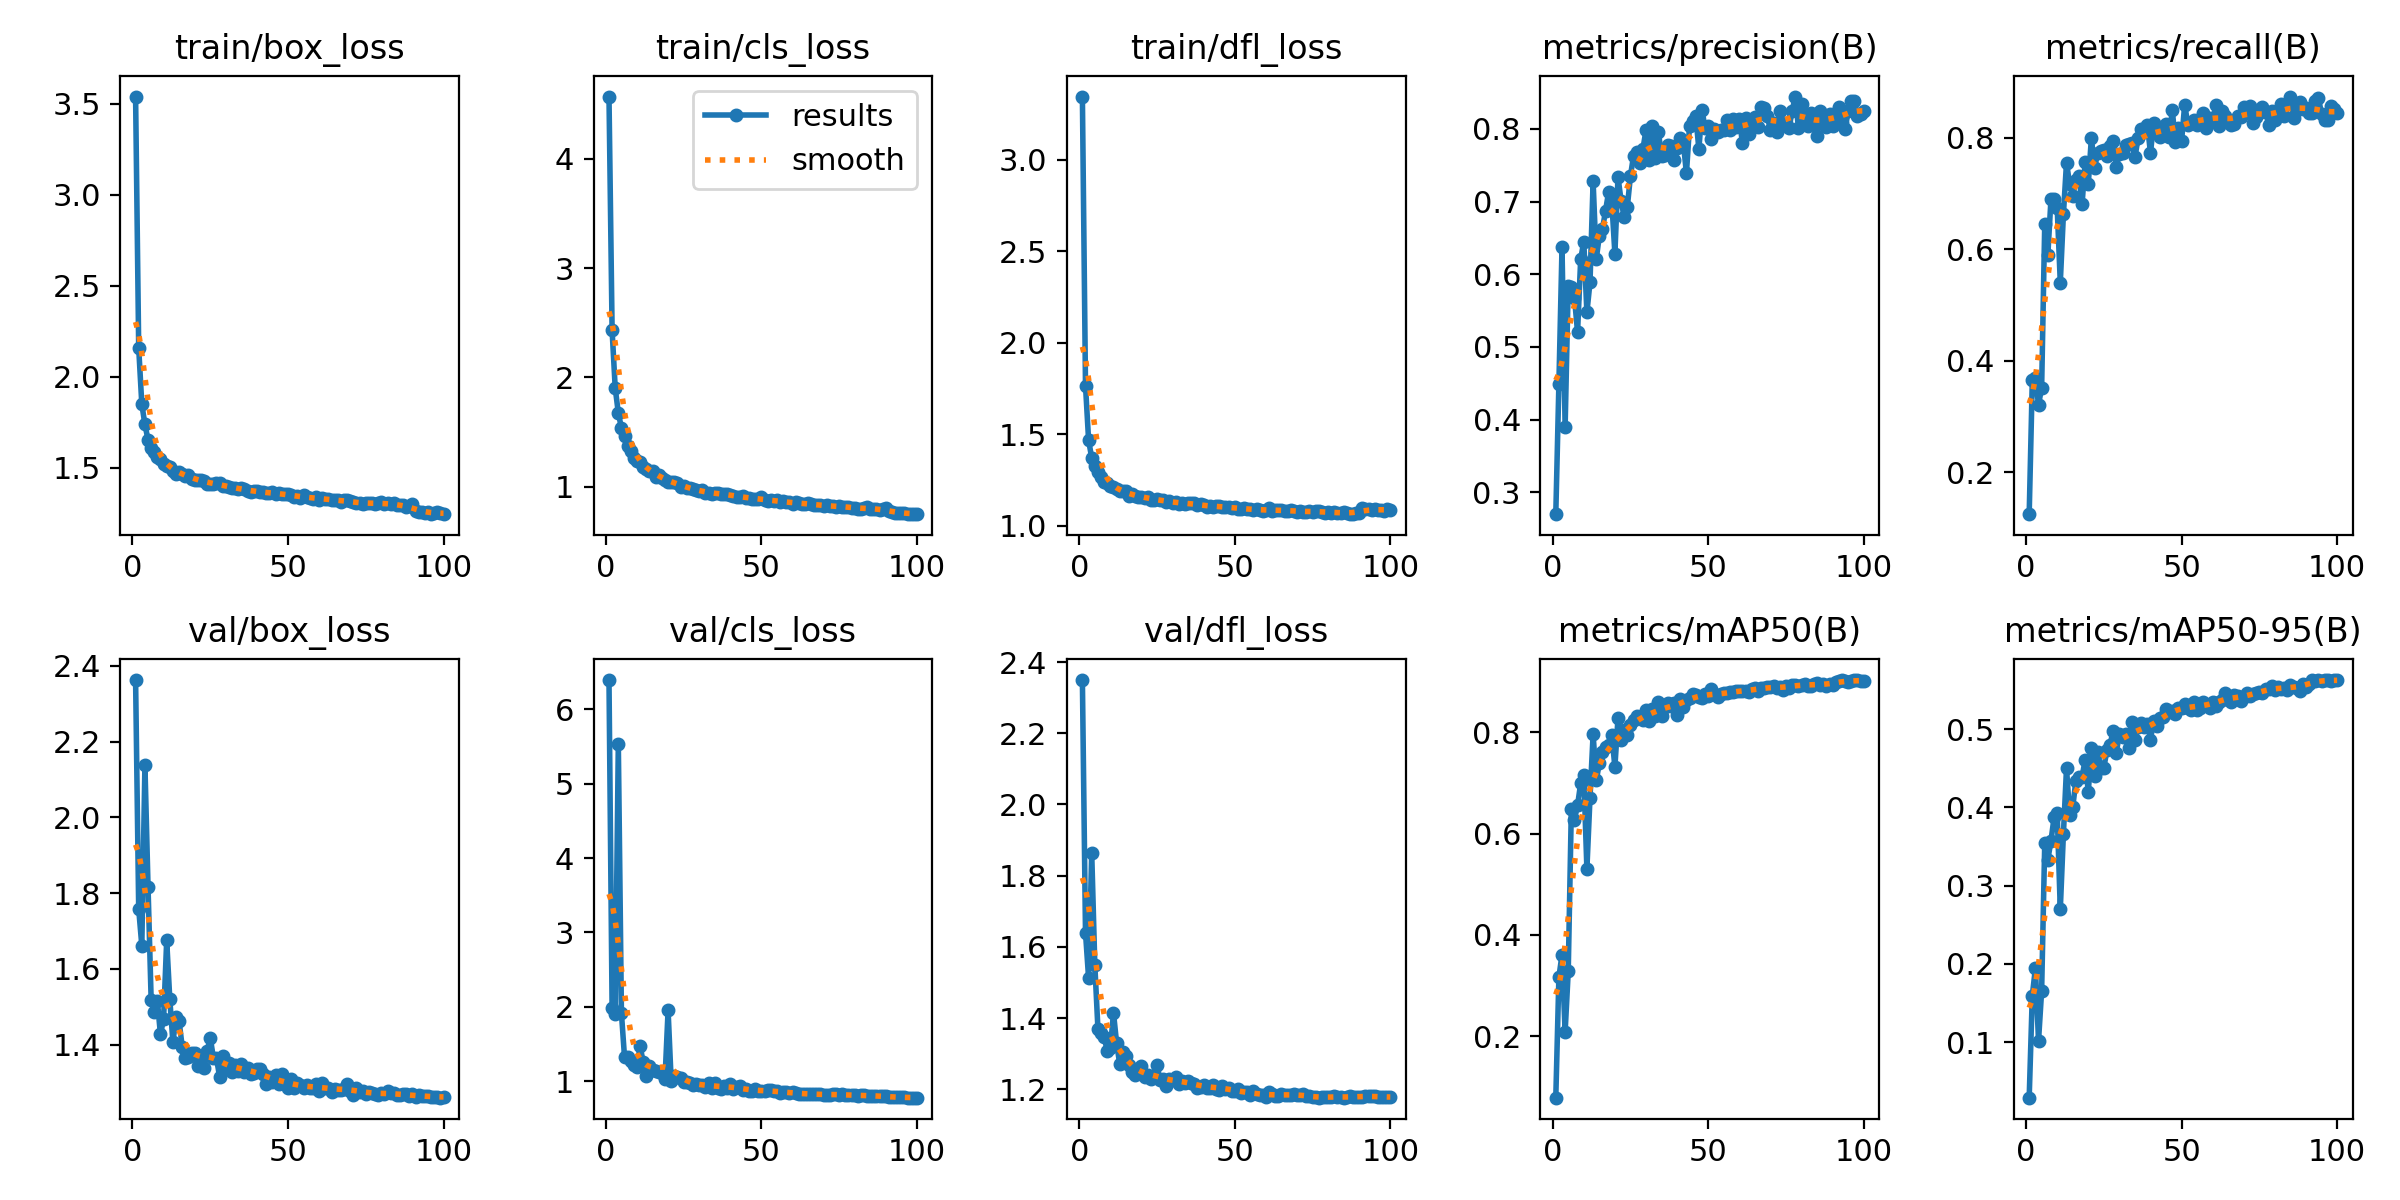

In [16]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [17]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['Platelets',
 'RBC',
 'WBC',
 'cast',
 'cryst',
 'epith',
 'epithn',
 'eryth',
 'leuko',
 'mycete']

In [18]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [19]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.5283659721268463
mAP 50 0.8322865701176421
mAP 75 0.6024205314115475


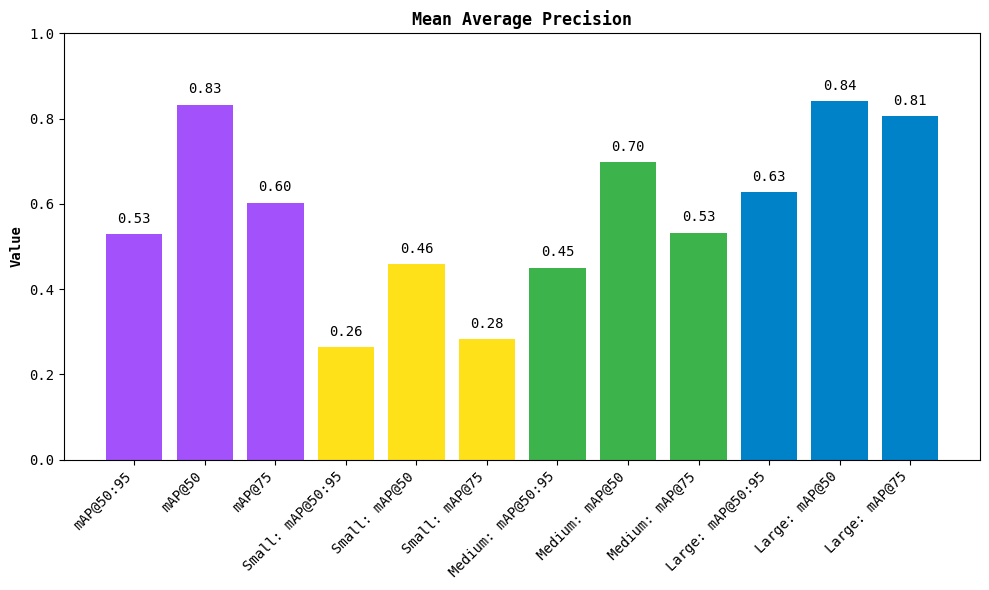

In [20]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [21]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

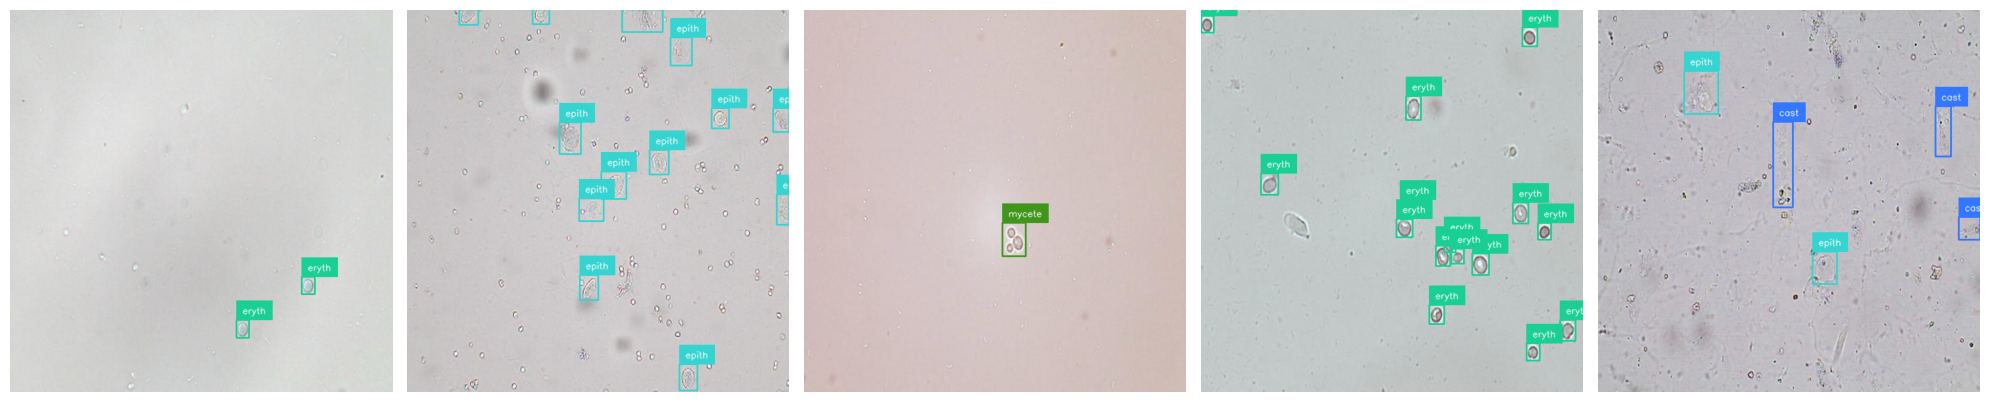

In [26]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for ax in axs:
    i = random.randint(0, len(ds)-1)
    image_path, image, target = ds[i]

    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results).with_nms()

    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    annotated_image = image.copy()
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    ax.imshow(annotated_image)
    ax.axis("off")

plt.tight_layout()
plt.show()
